Since SParck cannt deal with .h5 (or HDF5) file format (Hierarchical Data Format version 5) I was forced to mount my Databricks with the storage account directly, instead of grantin reading acces with the normal way we used to do with Spark.

I took the solution from: "https://www.databricks.com/notebooks/cnn-car-class/load-images-in-hdf5.html"

And in order to mount it, I had the problem that mounting a drive (dbutils.fs.mount) changes the file system for everyone on the cluster. Therefore, for security reasons, Databricks blocks this command on clusters shared by multiple users unless the cluster is "Dedicated" (assigned to a Single User).

so I went back a step, and changed the Access mode to single user from the cluster settings page, and I have assigned it to my account.
after that I was able to do the mounting and interact with the data.

In [0]:
# Add the Storage Account, Container, and reference the secret to pass the SAS Token
MOUNTPOINT = "/mnt/databricks/demo"
STORAGE_ACCOUNT = "scadatalake"
CONTAINER = "lakehouse"
SASTOKEN = "**************"

# Do not change these values
SOURCE = "wasbs://{container}@{storage_acct}.blob.core.windows.net/".format(container=CONTAINER, storage_acct=STORAGE_ACCOUNT)
URI = "fs.azure.sas.{container}.{storage_acct}.blob.core.windows.net".format(container=CONTAINER, storage_acct=STORAGE_ACCOUNT)

try:
  dbutils.fs.mount(
    source=SOURCE,
    mount_point=MOUNTPOINT,
    extra_configs={URI:SASTOKEN})
except Exception as e:
  if "Directory already mounted" in str(e):
    pass # Ignore error if already mounted.
  else:
    raise e
print("Success.")


Success.


In [0]:
%fs
ls /mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/

path,name,size,modificationTime
dbfs:/mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/ASCAD.h5,ASCAD.h5,46566904,1764064703000
dbfs:/mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/ASCAD_desync100.h5,ASCAD_desync100.h5,46566904,1764064703000
dbfs:/mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/ASCAD_desync50.h5,ASCAD_desync50.h5,46566904,1764064703000
dbfs:/mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5,ATMega8515_raw_traces.h5,6003842144,1764064733000


In [0]:
# Install h5py if not already installed
%pip install h5py

import h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/5.1 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 4.4/5.1 MB 132.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 89.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## Exploring the ASCAD.h5 dataset

In [0]:

file_path = "/dbfs/mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/ASCAD.h5"

# Open and inspect the HDF5 file
with h5py.File(file_path, "r") as f:
    def print_structure(name, obj):
        print(name)
    f.visititems(print_structure)

Attack_traces
Attack_traces/labels
Attack_traces/metadata
Attack_traces/traces
Profiling_traces
Profiling_traces/labels
Profiling_traces/metadata
Profiling_traces/traces


In [0]:

with h5py.File(file_path, "r") as f:
    attack_traces_count = f["Attack_traces/traces"].shape[0]
    profiling_traces_count = f["Profiling_traces/traces"].shape[0]
    print(f"Number of attack traces: {attack_traces_count}")
    print(f"Number of profiling traces: {profiling_traces_count}")

Number of attack traces: 10000
Number of profiling traces: 50000


Exploring the Profiling traces

In [0]:

with h5py.File(file_path, "r") as f:
    first_label = f["Profiling_traces/labels"][0]
    first_metadata = f["Profiling_traces/metadata"][0]
    first_trace = f["Profiling_traces/traces"][0][:10]
    print("First label:", first_label)
    print("First metadata:", first_metadata)
    print("First trace:", first_trace)

First label: 38
First metadata: ([  6,  65, 195,  66,  25, 182, 248,  19, 159, 132,  97,   6,  46, 137,  42,  16], [ 95,  75, 255, 146, 229,  35,  24,  50,  16, 107, 238,  33,  93,  56, 106, 178], [ 77, 251, 224, 242, 114,  33, 254,  16, 167, 141,  74, 220, 142,  73,   4, 105], [  7,  84,  71, 171, 129, 171,  90, 193, 236, 131,  21, 112, 185,  95, 212,  55], [0])
First trace: [ 20  19  13   6  -2 -10 -19 -29 -39 -47]


In [0]:
with h5py.File(file_path, "r") as f:
    first_trace = f["Profiling_traces/traces"][0]
    trace_length = len(first_trace)
    print("Length of trace:", trace_length)

Length of trace: 700


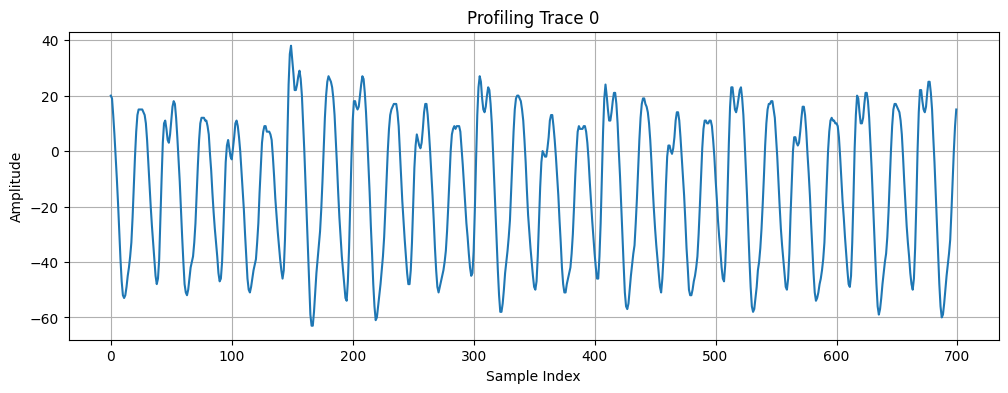

In [0]:
import matplotlib.pyplot as plt

with h5py.File(file_path, "r") as f:
    trace = f["Profiling_traces/traces"][0]

plt.figure(figsize=(12, 4))
plt.plot(trace)
plt.title("Profiling Trace 0")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

Exploring the Attack traces

In [0]:

with h5py.File(file_path, "r") as f:
    first_label = f["Attack_traces/labels"][0]
    first_metadata = f["Attack_traces/metadata"][0]
    first_trace = f["Attack_traces/traces"][0][:10]
    print("First label:", first_label)
    print("First metadata:", first_metadata)
    print("First trace:", first_trace)

First label: 214
First metadata: ([ 31, 172, 170, 167, 237,  34, 191,  94, 192, 195,  85, 125, 149,  46, 115, 121], [162,  37, 213,  18, 216,  58,  16,  67, 197, 193, 162, 176,  28,  84, 140,  38], [ 77, 251, 224, 242, 114,  33, 254,  16, 167, 141,  74, 220, 142,  73,   4, 105], [161, 165, 119, 180, 191, 232,  52,  24, 197,   7,  58,  87, 180,  44,  10, 121], [0])
First trace: [ 21  18  13   5  -4 -12 -21 -30 -40 -47]


In [0]:
with h5py.File(file_path, "r") as f:
    first_trace = f["Attack_traces/traces"][0]
    trace_length = len(first_trace)
    print("Length of trace:", trace_length)

Length of trace: 700


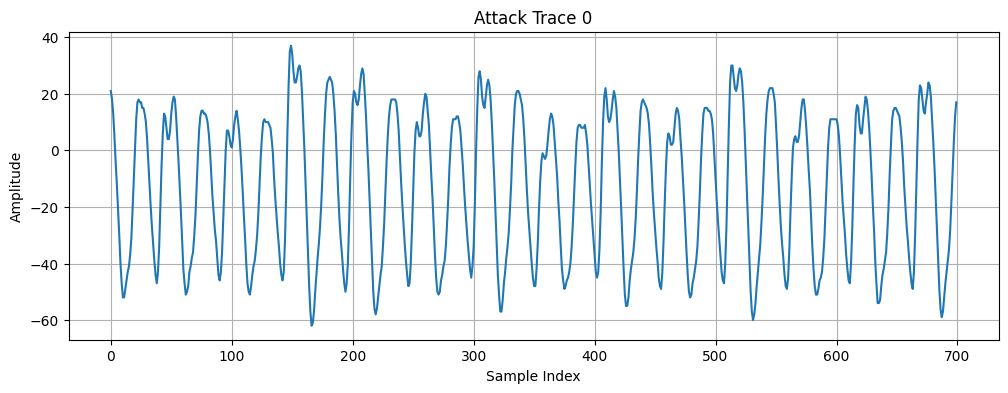

In [0]:

with h5py.File(file_path, "r") as f:
    trace = f["Attack_traces/traces"][0]

plt.figure(figsize=(12, 4))
plt.plot(trace)
plt.title("Attack Trace 0")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Exploring the Raw traces ATMega8515_raw_traces.h5 dataset

In [0]:

file_path = "/dbfs/mnt/databricks/demo/raw/ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5"

# Open and inspect the HDF5 file
with h5py.File(file_path, "r") as f:
    def print_structure(name, obj):
        print(name)
    f.visititems(print_structure)

metadata
traces


In [0]:
with h5py.File(file_path, "r") as f:
    traces_count = f["traces"].shape[0]
    print(f"Number of raw traces: {traces_count}")


Number of raw traces: 60000


In [0]:
with h5py.File(file_path, "r") as f:
    first_trace = f["traces"][0]
    trace_length = len(first_trace)
    print("Length of trace:", trace_length)

Length of trace: 100000


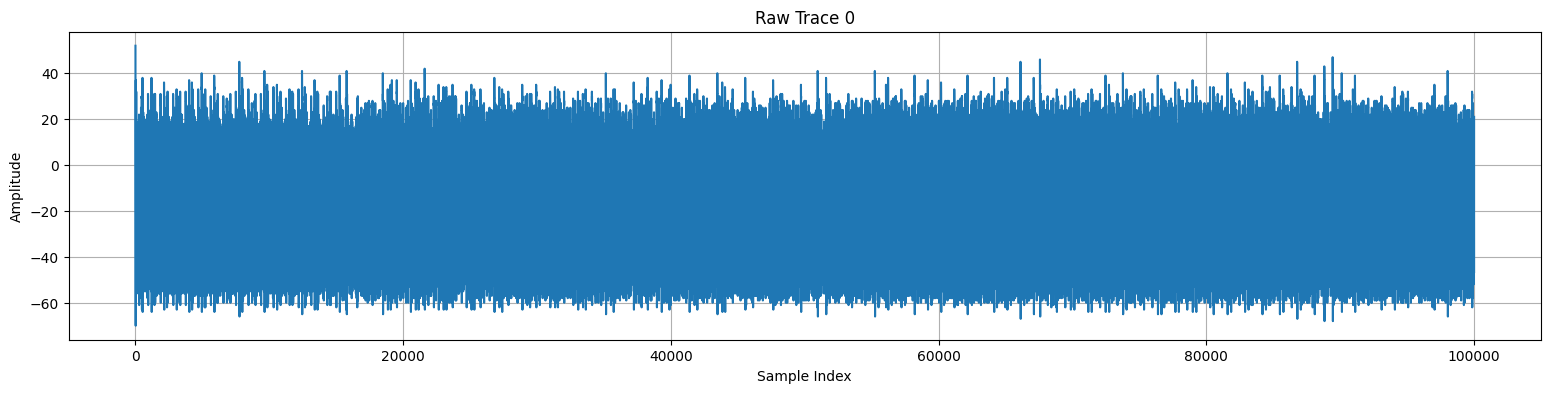

In [0]:
with h5py.File(file_path, "r") as f:
    trace = f["traces"][0]

plt.figure(figsize=(19, 4))
plt.plot(trace)
plt.title("Raw Trace 0")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Saving the Data to the gold layer since it is already clean and trimmed 

In [0]:
dbutils.fs.cp("dbfs:/mnt/databricks/demo/raw/ASCAD_data", "dbfs:/mnt/databricks/lakehouse/gold/ASCAD_data", recurse=True)

True

In [0]:
%fs
ls /mnt/databricks/lakehouse

path,name,size,modificationTime
dbfs:/mnt/databricks/lakehouse/gold/,gold/,0,1764071547000
